In [5]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [27]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels

train_images, train_labels = load_images_from_folder('flowers/train')
test_images, test_labels = load_images_from_folder('flowers/test')
validation_images, validation_labels = load_images_from_folder('flowers/validation')


In [11]:
def check_data_consistency(images, labels):
    assert len(images) == len(labels), "Number of images and labels do not match."
    unique_labels = set(labels)
    print(f"Total images: {len(images)}")
    print(f"Unique labels: {unique_labels}")
    for label in unique_labels:
        print(f"Number of images for {label}: {labels.count(label)}")

print("Train data summary")
check_data_consistency(train_images, train_labels)
print("-------------------------")
print("Test data summary")
check_data_consistency(test_images, test_labels)
print("-------------------------")
print("Validation data summary")
check_data_consistency(validation_images, validation_labels)

Train data summary
Total images: 6000
Unique labels: {'astilbe', 'rose', 'daisy', 'bellflower', 'iris', 'tulip', 'sunflower', 'water_lily', 'dandelion', 'carnation'}
Number of images for astilbe: 600
Number of images for rose: 600
Number of images for daisy: 600
Number of images for bellflower: 600
Number of images for iris: 600
Number of images for tulip: 600
Number of images for sunflower: 600
Number of images for water_lily: 600
Number of images for dandelion: 600
Number of images for carnation: 600
-------------------------
Test data summary
Total images: 500
Unique labels: {'astilbe', 'rose', 'daisy', 'bellflower', 'iris', 'tulip', 'sunflower', 'water_lily', 'dandelion', 'carnation'}
Number of images for astilbe: 50
Number of images for rose: 50
Number of images for daisy: 50
Number of images for bellflower: 50
Number of images for iris: 50
Number of images for tulip: 50
Number of images for sunflower: 50
Number of images for water_lily: 50
Number of images for dandelion: 50
Numbe

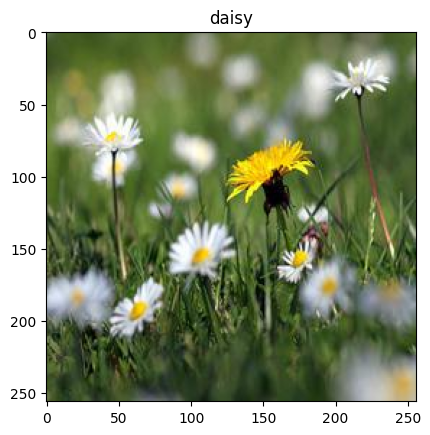

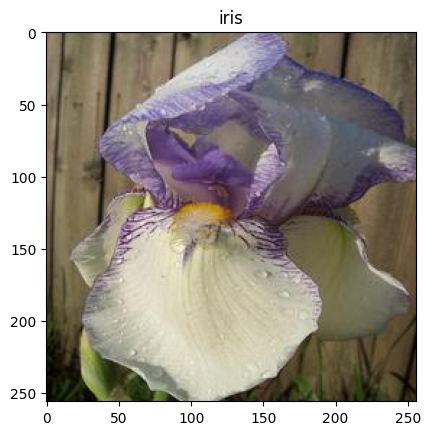

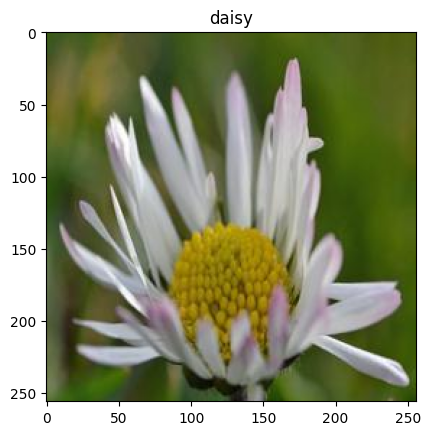

In [16]:
import matplotlib.pyplot as plt
import random

def display_sample_images(images, labels, num_samples=3):
    sample_indices = random.sample(range(len(images)), num_samples)
    for i in sample_indices:
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(labels[i])
        plt.show()

display_sample_images(train_images, train_labels)

# Steps

1. Imported necessary modules and created a pandas DataFrame with sample data.
2. Defined a function to load images from a folder and loaded train, test, and validation images and labels.
3. Defined a function to check the consistency of the loaded data and printed the summary for train, test, and validation data.
4. Defined a function to display sample images from the train data.
5. Defined a function to extract color histograms from the train images.

## Results

- The train, test, and validation data were loaded successfully.
- The train data consists of images from different classes, with a consistent number of images for each class.
- Sample images from the train data were displayed successfully.


In [19]:
def resize_image(image, size=(64, 64)):
    # Calculate the ratio of the desired size and the current size
    h, w = image.shape[:2]
    c = image.shape[2] if len(image.shape) > 2 else 1
    ratio = min(size[0]/h, size[1]/w)

    # Calculate new size
    new_size = (int(w * ratio), int(h * ratio))

    # Resize the image
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)

    # Create a new image and paste the resized image onto it
    new_image = np.zeros((size[0], size[1], c), dtype=image.dtype)
    new_image[:new_size[1], :new_size[0]] = resized_image

    return new_image

In [20]:
def convert_to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

In [46]:
# new function to load images and preprocess them
def load_and_preprocess_images(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    resized_img = resize_image(img)
                    hsv_img = convert_to_hsv(resized_img)
                    images.append(hsv_img)
                    labels.append(label)
    return images, labels

train_images, train_labels = load_and_preprocess_images('flowers/train')
test_images, test_labels = load_and_preprocess_images('flowers/test')
validation_images, validation_labels = load_and_preprocess_images('flowers/validation')

In [29]:
def extract_canny_edges(image):
    # Convert image to grayscale as Canny works on single channel
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Canny Edge Detector
    edges = cv2.Canny(gray, 100, 200)
    return edges.flatten()

In [30]:
def extract_sobel_edges(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Sobel Edge Detector
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    return sobel.flatten()


In [31]:
def create_feature_vector(image):
    # HSV Color Space Features
    hsv_features = convert_to_hsv(image).flatten()

    # Edge Features (choose either Canny or Sobel)
    edge_features = extract_canny_edges(image)  # or extract_sobel_edges(image)

    # Concatenate Features
    feature_vector = np.concatenate([hsv_features, edge_features])
    return feature_vector

In [47]:
# new function to load images, preprocess them and extract features
def load_and_extract_features(folder):
    feature_vectors = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    resized_img = resize_image(img)
                    feature_vector = create_feature_vector(resized_img)
                    feature_vectors.append(feature_vector)
                    labels.append(label)
    return feature_vectors, labels

train_features, train_labels = load_and_extract_features('flowers/train')
test_features, test_labels = load_and_extract_features('flowers/test')
validation_features, validation_labels = load_and_extract_features('flowers/validation')

In [48]:
# Determine the size of the feature vectors
def calculate_expected_vector_size():
    # Use a sample image to calculate sizes
    sample_image = train_images[0]

    # HSV feature size
    hsv_size = np.prod(convert_to_hsv(sample_image).shape)

    # Edge feature size (using Canny as an example)
    edge_size = np.prod(extract_canny_edges(sample_image).shape)

    # Total expected size
    return hsv_size + edge_size

expected_vector_size = calculate_expected_vector_size()

In [52]:
def test_feature_extraction(feature_vectors, labels):
    # Test 1: Feature Vector Size
    for vector in feature_vectors:
        assert len(vector) == expected_vector_size, f"Feature vector size is inconsistent. Expected size: {expected_vector_size}, but got size: {len(vector)}."
    print("Test 1 Passed: Feature vector size is consistent.")

    # Test 2: Data Integrity
    feature_array = np.array(feature_vectors)
    assert np.all(np.isfinite(feature_array)), "Feature vectors contain NaN or infinite values."
    print("Test 2 Passed: Feature vectors do not contain NaN or infinite values.")

    # Test 3: Label Matching
    assert len(feature_vectors) == len(labels), "Mismatch between number of feature vectors and labels."
    print("Test 3 Passed: Number of feature vectors matches number of labels.")

print("Train data summary")
test_feature_extraction(train_features, train_labels)
print("-------------------------")
print("Test data summary")
test_feature_extraction(test_features, test_labels)
print("-------------------------")
print("Validation data summary")
test_feature_extraction(validation_features, validation_labels)

Train data summary
Test 1 Passed: Feature vector size is consistent.
Test 2 Passed: Feature vectors do not contain NaN or infinite values.
Test 3 Passed: Number of feature vectors matches number of labels.
-------------------------
Test data summary
Test 1 Passed: Feature vector size is consistent.
Test 2 Passed: Feature vectors do not contain NaN or infinite values.
Test 3 Passed: Number of feature vectors matches number of labels.
-------------------------
Validation data summary
Test 1 Passed: Feature vector size is consistent.
Test 2 Passed: Feature vectors do not contain NaN or infinite values.
Test 3 Passed: Number of feature vectors matches number of labels.


1. Image Preprocessing: Created a function to resize images to a uniform size while maintaining the aspect ratio.
2. Color Space Conversion: Defined a function to convert images from RGB to HSV color space.
3. Edge Detection: Implemented functions for extracting shape features using Canny and Sobel edge detection methods.
4. Feature Concatenation: Developed a process to concatenate color and shape features into a single feature vector for each image.

---

- Successfully loaded and preprocessed images and labels for training, testing, and validation.
- Ensured that images across different datasets are consistent in terms of quantity and label distribution.
- Extracted and combined key features from images, including color information in HSV space and shape details via edge detection, forming comprehensive feature vectors for model input.

In [53]:
def calculate_entropy(y):
    class_labels = np.unique(y)
    entropy = 0
    for cls in class_labels:
        p = len(y[y == cls]) / len(y)
        entropy -= p * np.log2(p)
    return entropy

In [54]:
def calculate_information_gain(X, y, feature_index):
    # Total entropy before the split
    total_entropy = calculate_entropy(y)

    # Values and counts for the feature being split
    values, counts = np.unique(X[:, feature_index], return_counts=True)

    # Weighted entropy after split
    weighted_entropy = sum([(counts[i] / np.sum(counts)) * calculate_entropy(y[X[:, feature_index] == v]) for i, v in enumerate(values)])

    # Information gain is the entropy reduction
    information_gain = total_entropy - weighted_entropy
    return information_gain

---
Decision Tree

In [55]:
class DecisionTreeNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        # For decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # For leaf node
        self.value = value

In [56]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):
        X, y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)

        # Split until stopping conditions are met
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            # Find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split["info_gain"] > 0:
                # Recursively build left and right branches
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                return DecisionTreeNode(feature_index=best_split["feature_index"], threshold=best_split["threshold"], left=left_subtree, right=right_subtree, info_gain=best_split["info_gain"])

        # Compute leaf node value
        leaf_value = self.calculate_leaf_value(y)
        return DecisionTreeNode(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):
        # Dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")

        # Loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        return best_split

    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode == "gini":
            gain = self.gini_index(parent) - (weight_l * self.gini_index(l_child) + weight_r * self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))
        return gain

    def entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p = len(y[y == cls]) / len(y)
            entropy -= p * np.log2(p)
        return entropy

    def gini_index(self, y):
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p = len(y[y == cls]) / len(y)
            gini += p * (1 - p)
        return gini

    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)

    def fit(self, X, Y):
        dataset = np.concatenate((X, Y.reshape(-1, 1)), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions

    def make_prediction(self, x, tree):
        if tree.value != None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [44]:
def create_label_mapping(labels):
    unique_labels = np.unique(labels)
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    return label_mapping

# Create the label mapping for the train labels
label_mapping = create_label_mapping(train_labels)

# Print label mapping to verify
print("Label Mapping:", label_mapping)

Label Mapping: {'astilbe': 0, 'bellflower': 1, 'carnation': 2, 'daisy': 3, 'dandelion': 4, 'iris': 5, 'rose': 6, 'sunflower': 7, 'tulip': 8, 'water_lily': 9}


In [60]:
# Convert train, test, and validation labels to numeric labels
train_labels_numeric = np.array([label_mapping[label] for label in train_labels])
test_labels_numeric = np.array([label_mapping[label] for label in test_labels])
validation_labels_numeric = np.array([label_mapping[label] for label in validation_labels])

In [62]:
# Convert feature lists to numpy arrays
X_train = np.array(train_features)
y_train = train_labels_numeric
X_test = np.array(test_features)
y_test = test_labels_numeric

# Create and train the decision tree
decision_tree = DecisionTree(min_samples_split=2, max_depth=10)
decision_tree.fit(X_train, y_train)

# Make predictions on the test dataset
predictions = decision_tree.predict(X_test)

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix

# Construct the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Print the confusion matrix
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
# Calculate TP, FP, FN, and TN for each class
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (FP + FN + TP)

# Calculate Accuracy, Precision, Recall, and F1 Score for each class
accuracy_per_class = (TP + TN) / (TP + TN + FP + FN)
precision_per_class = TP / (TP + FP)
recall_per_class = TP / (TP + FN)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

# Calculate average of the metrics across all classes
average_accuracy = np.mean(accuracy_per_class)
average_precision = np.mean(precision_per_class)
average_recall = np.mean(recall_per_class)
average_f1 = np.mean(f1_per_class)

# Print the averaged metrics
print(f"Average Accuracy: {average_accuracy}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1 Score: {average_f1}")